In [ ]:
import json
import ROOT
from analysis_framework import Dataset
from WWAnalysis import WWAnalysis
import os
from alt_setup_creator import AltSetupHandler

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x75ef080


In [2]:
# ROOT.EnableImplicitMT(12)
os.environ["OMP_NUM_THREADS"] = "6"

In [3]:
# CLD
# x_angle = 0.030 # rad
# ILD
x_angle = 0.014 # rad

In [4]:
prod = False
no_rvec = False
output_collections = r"(\w*sqme\w*)|(weight\w*)"
dataset_path = "checked-test.json"
output_path = "data/snapshots/stage2-test"
output_meta = "stage2-test.json"
if prod:
    dataset_path = "checked-full.json"
    output_path = "data/snapshots/stage2"
    output_meta = "stage2-full.json"

In [5]:
# dataset = Dataset.from_json("checked-full.json")
# dataset = Dataset.from_json("checked-full-local.json")
dataset = Dataset.from_json(dataset_path)

In [6]:
analysis = WWAnalysis(dataset)
analysis.init_parameters([
    # ("WWCategorisation.RecoCatBasic", "int", "8"),
    # ("WWCategorisation.RecoCatAdvanced", "int", "8"),
    # ("WWCategorisation.missE", "float", "-42"),
    # ("WWCategorisation.misspT", "float", "-42"),
    # ("WWCategorisation.mInv", "float", "-42"),
    ("Energy", "float", "-42"),
    ("sqme", "float", "-42.0"),
])
analysis.init_categories()

Warning in <TClass::Init>: no dictionary for class edm4hep::Vector2i is available


In [ ]:
# alt_configs = {
#     "alt1": {
#         "g1z": 1.001,
#         "ka": 1.000,
#         "la": 0.000,
#     },
#     "alt2": {
#         "g1z": 1.000,
#         "ka": 1.001,
#         "la": 0.000,
#     },
#     "alt3": {
#         "g1z": 1.000,
#         "ka": 1.000,
#         "la": 0.001,
#     },
# }
alt_setup_handler = AltSetupHandler("alt-configs.json", mirror=True)
alt_configs = alt_setup_handler.get_alt_setup()
analysis.initialise_omega_wrappers(alt_configs)

In [8]:
mc_indices = {
    "beam_e_nominal": 0,
    "beam_p_nominal": 1,
    "beam_e_BES": 2,
    "beam_p_BES": 3,
    "beam_e_ISR": 4,
    "beam_p_ISR": 5,
    "up_type_q": 10,
    "down_type_q": 11,
    "charged_lep": 12,
    "neutrino": 13,
}
analysis.set_mc_indices(mc_indices)

In [9]:
# signal cut goes here:
# In this case, we want to require the charged lepton in the final state to be inside of the detector acceptance
# just take the first gen status 1 particle with a fitting pdg value and cut on theta
lep_pdg = 11
# CLD 150 mrad
# ILD ~84 mrad (IDR: 4.8 deg)
# acceptance_theta = 0.084
# signal_cut = f"""
# std::invoke([](auto& genStat, auto& pdg, auto& px, auto& py, auto& pz, auto& m) -> bool {{
# auto lepton_mask = genStat == 1 && abs(pdg) == {lep_pdg};
# // abuse ArgMax to get the first set position
# auto lepton_idx = ArgMax(lepton_mask);
# auto lepton_lvec = ROOT::Math::PxPyPzMVector(px[lepton_idx], py[lepton_idx],
#                                              pz[lepton_idx], m[lepton_idx]);
# double lepton_theta = lepton_lvec.Theta();
# return abs(cos(lepton_theta)) < cos({acceptance_theta});
# }}, MCParticlesSkimmed.generatorStatus, MCParticlesSkimmed.PDG, MCParticlesSkimmed.momentum.x, MCParticlesSkimmed.momentum.y, MCParticlesSkimmed.momentum.z, MCParticlesSkimmed.mass)
# """

In [10]:
# analysis.set_categories({
#     # TODO: actually implement the cut, but I might notice when refactoring the cut-flow...
#     # "4f_sw_sl_signal": {"pattern": "4f_sw_sl", "cut": "1 == 1"},
#     # TODO: in principle I would not need to define them like this again if I would use the information from the pre-selection but did not manage that on first try :(
#     "4f_sw_sl_signal": {"pattern": "4f_sw_sl", "cut": signal_cut},
#     "4f_sl_bkg": {"pattern": r"4f\w+sl", "cut": None }, # inverse signal cut will be applied automatically
#     "4f_not_sl": {"pattern": r"4f\w+_(?:h|l)", "cut": None },
#     # separate out aa_4f? super low lumi anyway
#     "aa2f": {"pattern": "aa_2f", "cut": None},
#     # 2f but not aa_2f
#     "2f": {"pattern": "(?<!aa_)2f", "cut": None},
#     "3f": {"pattern": "ea_3f|ae_3f", "cut": None},
#     "5f": {"pattern": "ea_5f|ae_5f", "cut": None},
#     "6f": {"pattern": "6f", "cut": None},
#     # need to filter out anything ending in _h and 2f_z_eehiq
#     "higgs": {"pattern": "[^_e]h", "cut": None},
# })
# check if we missed any processes
print(analysis.is_complete_categorisation())
analysis.set_signal_categories(["4f_sw_sl_signal"])

True


In [11]:
# FIXME: get rid of all the double signal_signal etc. :(
print(json.dumps(analysis._categories, indent=2))

{
  "4f_sw_sl_signal": [
    "4f_sw_sl_eLpR_signal",
    "4f_sw_sl_eRpL_signal"
  ],
  "4f_sl_bkg": [
    "4f_zz_sl_eLpR",
    "4f_sze_sl_eRpL",
    "4f_sze_sl_eLpR",
    "4f_sznu_sl_eLpR",
    "4f_sw_sl_eLpR_bkg"
  ],
  "4f_not_sl": [
    "4f_sw_l_eLpR",
    "4f_zz_h_eLpR",
    "4f_zz_l_eLpR",
    "4f_sznu_l_eLpR"
  ],
  "2f": [
    "2f_z_h_eLpR"
  ],
  "3f": [
    "ae_3f_z_l_eBpL"
  ],
  "6f": [
    "6f_llxyyx_eLpR",
    "6f_vvyyyy_eRpL",
    "6f_llyyyy_eRpL"
  ],
  "higgs": [
    "e1e1h_eLpR",
    "n1n1h_eLpR",
    "qqh_eLpR",
    "e2e2h_eLpR",
    "qqh_eRpL",
    "n1n1h_eRpL",
    "e1e1h_eRpR",
    "n23n23h_eRpL",
    "e1e1h_eLpL"
  ]
}


In [12]:
# needed for the .size() calls... alternative would probably be to .Alias the @size columns
ROOT.gInterpreter.Declare("#include <podio/ObjectID.h>")
ROOT.gInterpreter.Declare("#include <edm4hep/ReconstructedParticleData.h>")
make_lvec = lambda coll_name: f"ROOT::VecOps::Construct<ROOT::Math::PxPyPzEVector>({coll_name}.momentum.x, {coll_name}.momentum.y, {coll_name}.momentum.z, {coll_name}.energy)"
analysis.Define("R2jet_lvecs", make_lvec("Refined2Jets"))

In [13]:
signal_category = ["4f_sw_sl_signal"]
# analysis.define_truth_objects(signal_category)
analysis.book_weights()
# now already happens in pre-selection
# analysis.define_reco_objects(x_angle)
# analysis.remove_x_angle(x_angle)
# analysis.define_hagiwara_angles()
analysis.calc_reco_sqme()

In [14]:
# filter on missing energy > 0
analysis.Define("nu_E", "ub_nu_lvec.energy()")
# analysis.Define("M_Wlep", "ub_leptonic_W_lvec.M()")
analysis.Define("M_Whad", "ub_hadronic_W_lvec.M()")
# analysis.add_filter("M_Wlep > 0.", "Wlep real")

In [15]:
# analysis.book_reports()

In [16]:
sample_conf = list(alt_configs.keys())[0]
sample_weight = f"weight_{sample_conf}"
analysis.book_histogram_1D(sample_weight, sample_weight, ("", f";{sample_weight}", 50, 0.8, 1.2), categories=signal_category)

In [17]:
analysis.book_snapshots("events", output_path, output_meta, output_collections, no_rvec=no_rvec)

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x19a832b0


In [18]:
%%time
analysis.run()

CPU times: user 3h 13min 30s, sys: 2min 19s, total: 3h 15min 49s
Wall time: 33min 25s


(<cppyy.gbl.THStack object at 0x22224560>,
 <cppyy.gbl.TCanvas object at 0x2025bae0>)

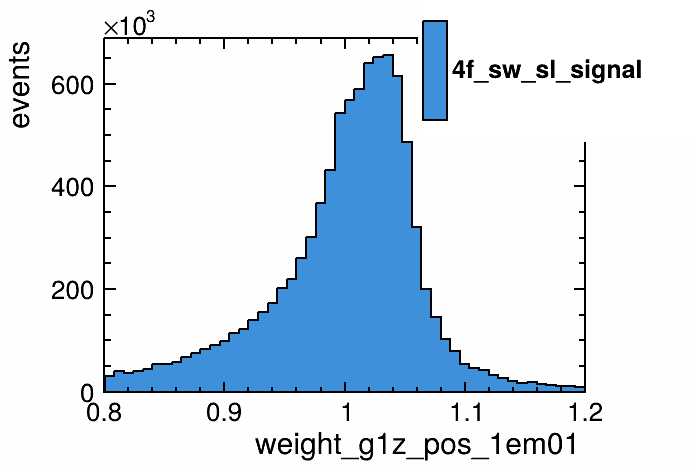

In [19]:
analysis.draw_histogram(sample_weight, categories=signal_category)